# Spam Detection with Random Forest

This beginner-friendly notebook walks through a basic Natural Language Processing (NLP) workflow using SMS spam detection as the use case.

We will:
- Preprocess text data (cleaning, tokenizing, vectorizing)
- Train a Random Forest classifier
- Perform feature selection using feature importances
- Use GridSearchCV for hyperparameter tuning
- Visualize key results

The dataset is the classic `spam.csv` file containing ~5.5k SMS messages labeled as "ham" (not spam) or "spam".


In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

## Load & Preview the Dataset

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1', usecols=[0, 1], names=['label', 'text'], skiprows=1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Class Distribution

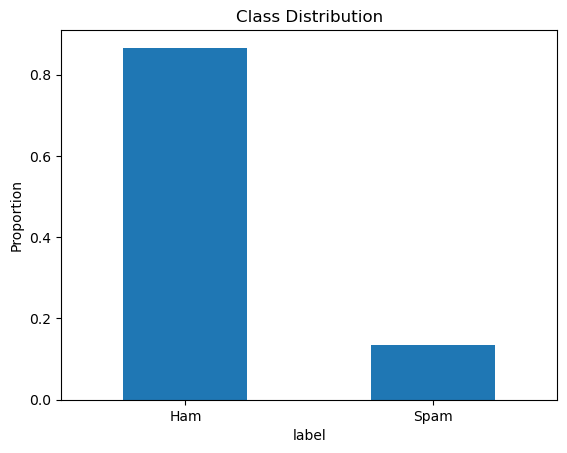

In [6]:
df['label'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)
plt.ylabel('Proportion')
plt.savefig("class_balance.png", dpi=150, bbox_inches="tight")
plt.show()

## Preprocessing Function

In [8]:
def clean_text(text):
    return ''.join([ch for ch in text if ch not in string.punctuation]).lower()
print(clean_text("Hello, World!"))

hello world


## Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=RANDOM_STATE
)

## Vectorization with TF-IDF

In [12]:
tfidf = TfidfVectorizer(
    preprocessor=clean_text,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

## Baseline Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train_vec.toarray(), y_train)
y_pred = rf.predict(X_test_vec.toarray())
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9721973094170404
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



## Feature Importance & Selection

In [16]:
importances = rf.feature_importances_
features = tfidf.get_feature_names_out()
feat_df = pd.DataFrame({'term': features, 'importance': importances})
feat_df = feat_df[feat_df['importance'] > 0.001].sort_values('importance', ascending=False)
feat_df.head(10)

,term,importance
6453,txt,0.029323
2424,free,0.023416
1442,claim,0.022668
4185,mobile,0.021105
7032,won,0.016400
5201,reply,0.015578
4963,prize,0.014721
5497,service,0.014556
5875,stop,0.014384
6123,text,0.011978


## Re-Vectorize with Selected Features

In [18]:
selected_terms = feat_df['term'].tolist()
tfidf_sel = TfidfVectorizer(
    preprocessor=clean_text,
    stop_words='english',
    vocabulary=selected_terms
)
X_train_sel = tfidf_sel.fit_transform(X_train)
X_test_sel = tfidf_sel.transform(X_test)

## GridSearchCV with Selected Features

In [20]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid={
        'n_estimators': [200, 400],
        'max_depth': [None, 25],
        'min_samples_split': [2, 5]
    },
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_sel.toarray(), y_train)
print('Best Params:', grid.best_params_)

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## Final Model Evaluation

Final Accuracy: 0.9775784753363229
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



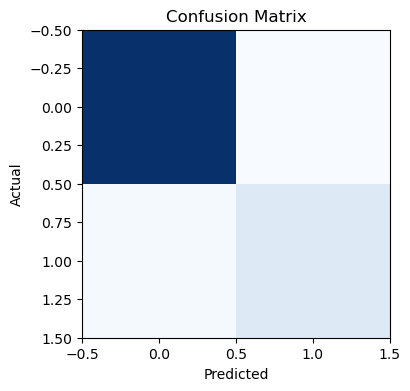

In [22]:
final_rf = grid.best_estimator_
y_final = final_rf.predict(X_test_sel.toarray())
print('Final Accuracy:', accuracy_score(y_test, y_final))
print(classification_report(y_test, y_final))
confusion = confusion_matrix(y_test, y_final)
plt.figure(figsize=(4,4))
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Classification Metrics Summary

Now we compute key classification metrics discussed in the classification module:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **Confusion matrix**

In [24]:
acc = accuracy_score(y_test, y_final)
prec = precision_score(y_test, y_final)
rec = recall_score(y_test, y_final)
f1 = f1_score(y_test, y_final)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

Accuracy:  0.9776
Precision: 0.9559
Recall:    0.8725
F1-score:  0.9123


## Conclusions

✅ We built a spam classifier using Random Forest and TF-IDF vectorization.  
✅ Feature importance was used to reduce dimensionality.  
✅ GridSearchCV allowed us to improve performance further.  

**Next ideas:**  
- Compare with Logistic Regression or SVM  
- Try `class_weight='balanced'` for class imbalance  
- Explore character-level n-grams  
